## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [2]:
# importing voting records
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
import pandas as pd

df = pd.read_csv('house-votes-84.data', 
                 header=None,
                 names=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa'])

import numpy as np

df = df.replace({'?':np.NaN,'y':1,'n':0})
print(df.shape)
df.head()

--2019-10-09 14:32:49--  https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18171 (18K) [application/x-httpd-php]
Saving to: ‘house-votes-84.data’

house-votes-84.data 100%[===================>]  17.75K  --.-KB/s    in 0.06s   

2019-10-09 14:32:49 (287 KB/s) - ‘house-votes-84.data’ saved [18171/18171]

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [29]:
df=df.dropna()
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
19,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
23,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [30]:
water = df['water-project'].to_numpy()
water

array([1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 1.

In [2]:
dem = df[df['party']== 'democrat']
print(dem.shape)
dem.head()

(267, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
6,democrat,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,1.0,1.0


In [4]:
dem = dem.dropna()
dem.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
19,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
23,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
26,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [0]:
water = dem[['water-project']].to_numpy()
water

In [0]:
#find the confidence interval     
from scipy import stats

def confidence_interval(data, confidence):
  data = np.array(data)
  mean = np.mean(data)
  n = len(data) #n = sample size
  stderr = stats.sem(data)
  margin = stderr * t.ppf(((1 + confidence) / 2.0), (n-1)) #error is here
  return mean, mean - margin, mean + margin

In [0]:
import scipy
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a,nan_policy='omit')
    h = se * stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [0]:
def confidence_int(input_data, confidence_level=95):
  data = input_data.dropna() #make sure the input data has no NaN values, and is in an array format
  mean = np.mean(data) #mean of the points in the dataset
  n = len(data) #number of data points in the dataset
  sem = stats.sem(data) #SEM — the standard error of the mean (or standard error of measurement)
  margin_of_error = sem * stats.t.ppf((1 + confidence_level)/2.0, (n - 1))
  lower_bound = mean - margin_of_error
  upper_bound = mean + margin_of_error
  print(' Mean: ', mean, '\n Lower Bound: ', lower_bound, '\n Upper Bound: ', upper_bound, margin_of_error,sem,n)
  return (mean, lower_bound, upper_bound)

In [11]:
confidence_interval(df['water-project'].dropna(),95)

(0.5038759689922481, nan, nan)

In [14]:
from scipy.stats import sem, t
from scipy import mean
confidence = 0.95
data = df['water-project'].dropna()

n = len(data)
m = mean(data)
std_err = sem(data)
h = std_err * t.ppf((1 + confidence) / 2, n - 1)

start = m - h
end = m + h
print(start,m, end)

0.45384081311663604 0.5038759689922481 0.5539111248678601


In [0]:
def confi_int(data,confidence):
  confidence = 0.95
  data = (data)

  n = len(data)
  m = mean(data)
  std_err = sem(data)
  h = std_err * t.ppf((1 + confidence) / 2, n - 1)

  start = m - h
  end = m + h
  return (m, start , end)

In [26]:
confi_int(df['water-project'].dropna(),95)

(0.5038759689922481, 0.45384081311663604, 0.5539111248678601)

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


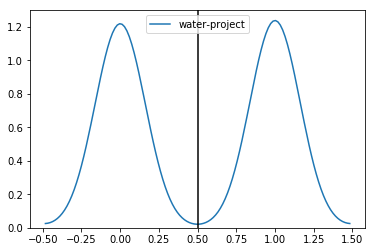

In [18]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.kdeplot(df['water-project'])
CI = confidence_interval(df['water-project'].dropna(),95)
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[2], color='red')
plt.axvline(x=CI[0], color='k');

/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/usr/local/lib/python3.6/dist-packages/statsmodels/nonparametric/kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


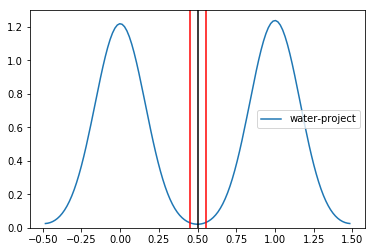

In [27]:
sns.kdeplot(df['water-project'])
CI = confi_int(df['water-project'].dropna(),95)
plt.axvline(x=CI[1], color='red')
plt.axvline(x=CI[2], color='red')
plt.axvline(x=CI[0], color='k');

part2 chi test 

In [105]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data


--2019-10-08 22:06:34--  https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51867 (51K) [application/x-httpd-php]
Saving to: ‘car.data’

car.data            100%[===================>]  50.65K  --.-KB/s    in 0.1s    

2019-10-08 22:06:35 (394 KB/s) - ‘car.data’ saved [51867/51867]



In [116]:

car_header = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class_value']
car_df = pd.read_csv('car.data',names=car_header)
car_df = car_df.drop(columns=['class_value'])
car_df.head()

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med


In [117]:
car_df.shape

(1728, 6)

In [110]:
car_df.describe(exclude='number')

,buying,maint,doors,persons,lug_boot,safety
count,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3
top,med,med,4,4,med,med
freq,432,432,432,576,576,576


In [120]:
contin_table = pd.crosstab(car_df['buying'],car_df['safety'],margins=True)
contin_table

safety,high,low,med,All
buying,,,,
high,144,144,144,432
low,144,144,144,432
med,144,144,144,432
vhigh,144,144,144,432
All,576,576,576,1728


In [122]:
buying_high = contin_table.iloc[0][0:3].values
buying_high

array([144, 144, 144])

In [123]:
buying_low = contin_table.iloc[2][0:3].values
buying_low

array([144, 144, 144])

In [125]:
row_sums = contin_table.iloc[0:4, 3].values
col_sums = contin_table.iloc[4, 0:3].values

print(row_sums)
print(col_sums)

[432 432 432 432]
[576 576 576]


In [126]:
total = contin_table.loc['All','All']
total

1728

In [127]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
  

expected = np.array(expected)
print(expected.shape)  
print(expected)

(4, 3)
[[144. 144. 144.]
 [144. 144. 144.]
 [144. 144. 144.]
 [144. 144. 144.]]


In [129]:
observed = pd.crosstab(car_df['buying'], car_df['safety']).values
print(observed.shape)
observed

(4, 3)


array([[144, 144, 144],
       [144, 144, 144],
       [144, 144, 144],
       [144, 144, 144]])

In [130]:
# Array broadcasting will work with numpy arrays but not python lists
chi_squared = ((observed - expected)**2/(expected)).sum() 
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 0.0


In [131]:
# Calculate Degrees of Freedom
dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f"Degrees of Freedom: {dof}")   

Degrees of Freedom: 6


In [133]:
#chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 0.0
P-value: 1.0
Degrees of Freedom: 6
Expected: 
 [[144. 144. 144.]
 [144. 144. 144.]
 [144. 144. 144.]
 [144. 144. 144.]]


## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)